In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE, resize
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
from scipy.ndimage import label, find_objects
from sklearn.model_selection import train_test_split

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=00cb16401abdbe48c93b916a882134215117d4e6b52e1107c23c6055ca71c868
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [4]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/masks/")

In [5]:
from imutils import paths

path_mask = list(paths.list_images("../input/chest-xray-masks-and-labels/Lung Segmentation/masks/"))
path_image = list(paths.list_images("../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/"))

In [6]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

print("Total Masks:", len(mask))
print("Total Masks:", len(image_file_name))
print("Extracted Mask Names:", mask[:5])
print("Image File Names:", image_file_name[:5])

Total Masks: 704
Total Masks: 704
Extracted Mask Names: ['CHNCXR_0300_0_mask', 'CHNCXR_0083_0_mask', 'CHNCXR_0094_0_mask', 'CHNCXR_0597_1_mask', 'MCUCXR_0017_0']
Image File Names: ['CHNCXR_0300_0', 'CHNCXR_0083_0', 'CHNCXR_0094_0', 'CHNCXR_0597_1', 'MCUCXR_0017_0']


In [7]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


# Resizing

In [8]:
size = (256, 256)
def image_resize(img):
    return cv2.resize(img,size )

In [9]:
x = np.array([np.array(np.stack(( image_resize(cv2.imread(os.path.join(image_path,filename.split("_mask")[0]+".png"),  0)),), axis=-1)) for filename in image_file_name])
y= np.array([np.array(np.stack(( cv2.resize(cv2.imread(filename, 0), (256,256)),), axis=-1)) for filename in path_mask])

In [10]:
print(x.shape, y.shape)

(704, 256, 256, 1) (704, 256, 256, 1)


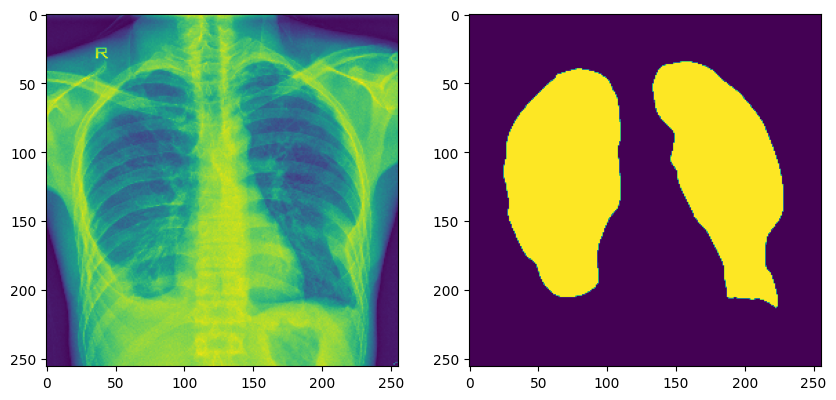

In [11]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(x[11])
plt.subplot(122)
plt.imshow(y[11])
plt.show()

# Image Augmentation

In [12]:
x_flip = np.flip(x, axis=2)
y_flip = np.flip(y, axis=2)

# Rotate images and masks 90 degrees counterclockwise (rotating along axes 1 and 2)
x_rotated = np.rot90(x, k=1, axes=(1, 2))
y_rotated = np.rot90(y, k=1, axes=(1, 2))

# Rotate flipped images and masks 90 degrees counterclockwise (rotating along axes 1 and 2)
x_flip_rotated = np.rot90(x_flip, k=1, axes=(1, 2))
y_flip_rotated = np.rot90(y_flip, k=1, axes=(1, 2))

# Concatenate original, flipped, rotated, and flipped + rotated images and masks
X = np.concatenate((x, x_flip, x_rotated, x_flip_rotated), axis=0)
Y = np.concatenate((y, y_flip, y_rotated, y_flip_rotated), axis=0)

# Print the shapes to verify that the number of images has doubled and transformed
print("X Shape: ", X.shape, "Y Shape: ", Y.shape)

X Shape:  (2816, 256, 256, 1) Y Shape:  (2816, 256, 256, 1)


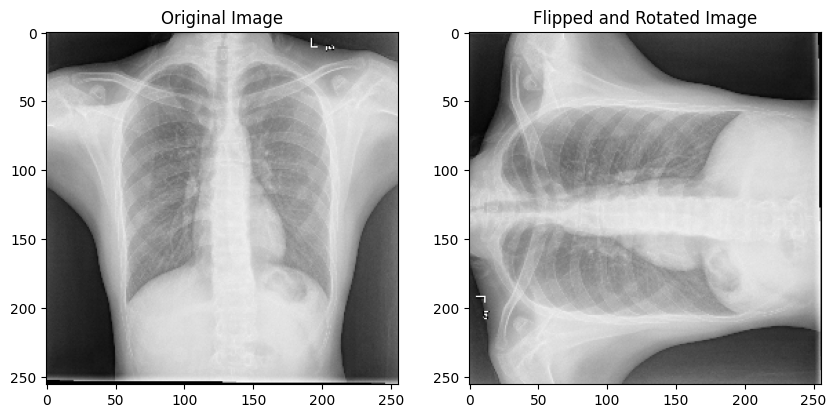

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image (first from the dataset)
axes[0].imshow(x[0].squeeze(), cmap='gray')
axes[0].set_title("Original Image")

# Rotated and flipped image (first after transformation)
axes[1].imshow(x_flip_rotated[0].squeeze(), cmap='gray')
axes[1].set_title("Flipped and Rotated Image")

plt.show()

# train test split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Normalization

In [15]:
x_train_norm = x_train/255.
x_test_norm = x_test/255.

y_train_norm = (y_train/255. > 0.5).astype(int)
y_test_norm = (y_test/255. > 0.5).astype(int)

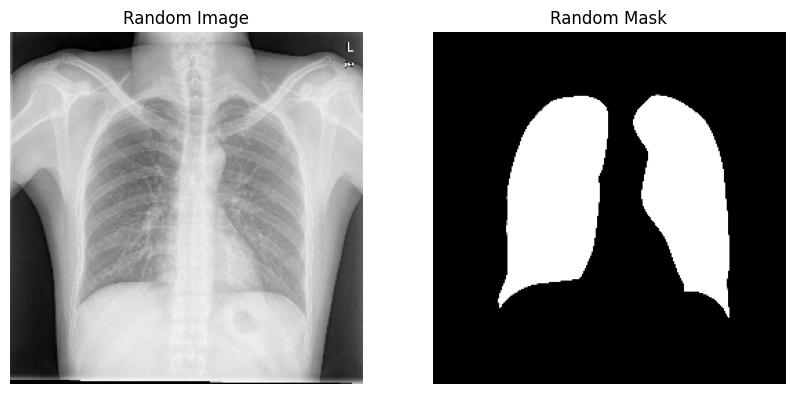

In [16]:
def display_random_image_and_mask(x, y):
    # Select a random index from the dataset
    random_index = np.random.randint(0, x.shape[0])

    # Retrieve the image and mask corresponding to the random index
    random_image = x[random_index].squeeze()  # Remove the extra channel dimension
    random_mask = y[random_index].squeeze()  # Remove the extra channel dimension

    # Plot the image and its corresponding mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the image
    axes[0].imshow(random_image, cmap='gray')
    axes[0].set_title("Random Image")
    axes[0].axis('off')

    # Display the mask
    axes[1].imshow(random_mask, cmap='gray')
    axes[1].set_title("Random Mask")
    axes[1].axis('off')

    plt.show()

# Example usage: 
display_random_image_and_mask(x, y)

# u-net model 

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet(input_size=(256,256,1)):
    inputs=Input(input_size)

    #encoder
    conv1= Conv2D(32,(3,3), activation='relu', padding='same')(inputs)
    conv1= Conv2D(32,(3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)


    conv2= Conv2D(64,(3,3), activation='relu', padding='same')(pool1)
    conv2= Conv2D(64,(3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)


    conv3= Conv2D(128,(3,3), activation='relu', padding='same')(pool2)
    conv3= Conv2D(128,(3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4= Conv2D(256,(3,3), activation='relu', padding='same')(pool3)
    conv4= Conv2D(256,(3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    #bottleneck
    conv5= Conv2D(512,(3,3), activation='relu', padding='same')(pool4)
    conv5= Conv2D(512,(3,3), activation='relu', padding='same')(conv5)

    #decoder
    up6 = concatenate([Conv2DTranspose(256,(2,2), strides=(2,2), padding='same')(conv5),conv4], axis=3)
    conv6=Conv2D(256,(3,3), activation='relu', padding='same')(up6)
    conv6=Conv2D(256,(3,3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128,(2,2), strides=(2,2), padding='same')(conv6),conv3], axis=3)
    conv7=Conv2D(128,(3,3), activation='relu', padding='same')(up7)
    conv7=Conv2D(128,(3,3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(conv7),conv2], axis=3)
    conv8=Conv2D(64,(3,3), activation='relu', padding='same')(up8)
    conv8=Conv2D(64,(3,3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(conv8),conv1], axis=3)
    conv9=Conv2D(32,(3,3), activation='relu', padding='same')(up9)
    conv9=Conv2D(32,(3,3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    return Model(inputs=[inputs], outputs=[conv10]) 



In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau  

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    mode='min'
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    verbose=1, 
    mode='min', 
    min_delta=0.0001, 
    cooldown=2, 
    min_lr=1e-6
)

early = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=8
)

callbacks_list = [checkpoint, early, reduceLROnPlat]


In [20]:
from tensorflow.keras.losses import binary_crossentropy

model = unet(input_size=(256,256,1))

model.compile(optimizer=Adam(), loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# loss_history = model.fit(x = x_train_norm,
#                          y = y_train_norm,
#                          batch_size = 8,
#                   epochs = 15)

In [22]:
history = model.fit(
    x=x_train_norm,
    y=y_train_norm,
    validation_data=(x_test_norm, y_test_norm),  # Include validation data for `val_loss`
    batch_size=8,
    epochs=8,
    callbacks=callbacks_list  # Include the callbacks here
)

Epoch 1/8


I0000 00:00:1734221952.767534     106 service.cc:145] XLA service 0x7b84a0021ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734221952.767598     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734221952.767602     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734221975.229384     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8025 - loss: 0.4101
Epoch 1: val_loss improved from inf to 0.22628, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 90s 223ms/step - accuracy: 0.8028 - loss: 0.4097 - val_accuracy: 0.9230 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 2/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9530 - loss: 0.1281
Epoch 2: val_loss improved from 0.22628 to 0.07167, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - accuracy: 0.9530 - loss: 0.1280 - val_accuracy: 0.9737 - val_loss: 0.0717 - learning_rate: 0.0010
Epoch 3/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9750 - loss: 0.0682
Epoch 3: val_loss improved from 0.07167 to 0.06402, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.9750 - loss: 0.0681 - val_accuracy: 0.9764 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 4/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0

In [23]:
loss, accuracy = model.evaluate(x_test_norm, y_test_norm)
print(f"Test Accuracy: {accuracy * 100:.4f}%")

2024-12-15 00:26:48.403014: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-15 00:26:48.496723: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.093835846s
Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","w

18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9807 - loss: 0.0511 
Test Accuracy: 97.9721%


In [24]:
output_dir = 'kaggle/output'

os.makedirs(output_dir, exist_ok=True)

model.save(os.path.join(output_dir, 'unet_new_2.keras'))

In [25]:
pred_candidates = np.random.randint(1,x_test_norm.shape[0],10)
preds = model.predict(x_test_norm)

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step


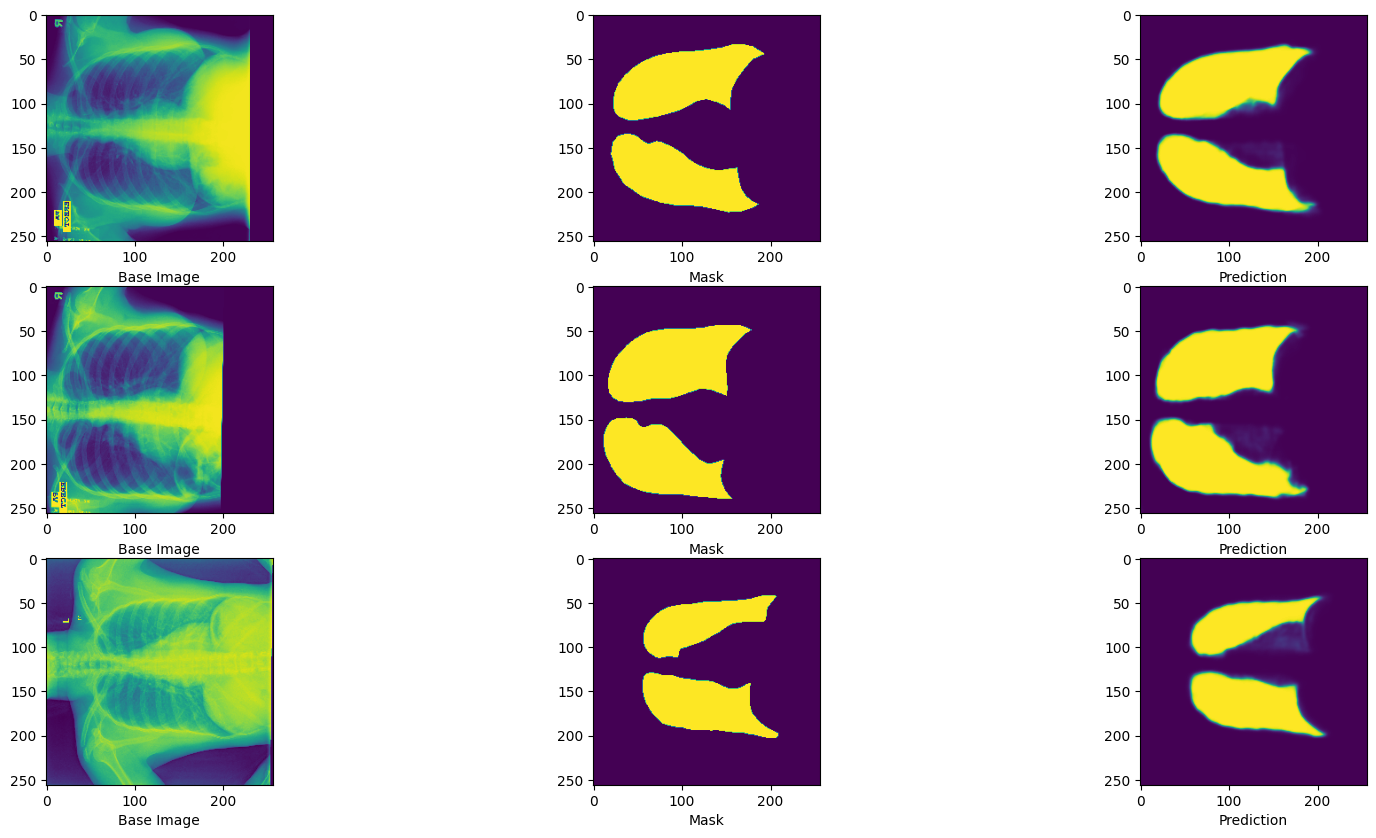

In [26]:
plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(x_test_norm[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(y_test_norm[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")

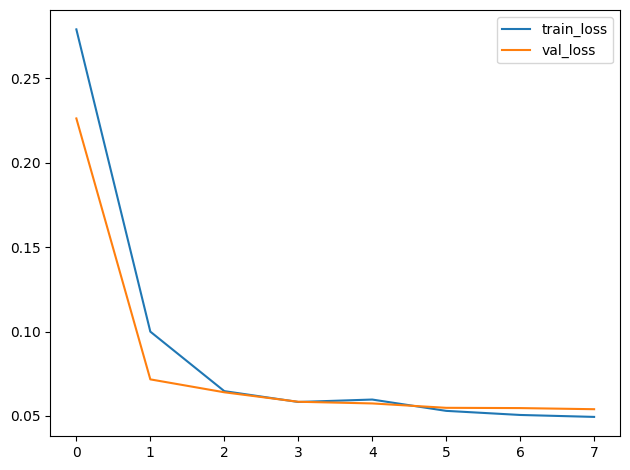

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()



plt.tight_layout()
plt.show()

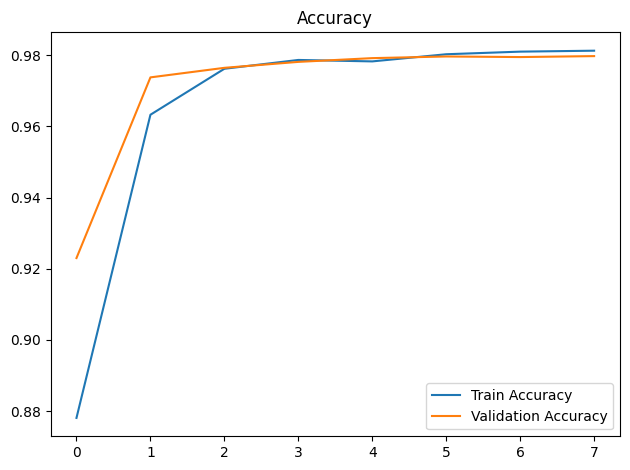

In [28]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Convert y_true to float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))  # Convert y_pred to float32
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    
def combined_loss(y_true, y_pred):
    bce = binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


In [30]:
print(y_train_norm.dtype)
print(y_test_norm.dtype)


int64
int64


In [31]:
y_train_norm = y_train_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)


In [32]:
print(np.unique(y_train_norm))
print(np.unique(y_test_norm))


[0. 1.]
[0. 1.]


In [33]:
print(f"Shape of y_train_norm: {y_train_norm.shape}")
print(f"Shape of y_test_norm: {y_test_norm.shape}")


Shape of y_train_norm: (2252, 256, 256, 1)
Shape of y_test_norm: (564, 256, 256, 1)


In [34]:
print(f"Total samples in y_train_norm: {y_train_norm.shape[0]}")


Total samples in y_train_norm: 2252


In [35]:
# Calculate the split index for an 80-20 split
split_index = int(0.8 * y_train_norm.shape[0])  # 80% for training

# Split the data
x_train_norm, y_train_norm = X[:split_index], Y[:split_index]
x_test_norm, y_test_norm = X[split_index:], Y[split_index:]

# Check the shapes of the split data
print(f"Shape of y_train_norm after split: {y_train_norm.shape}")
print(f"Shape of y_test_norm after split: {y_test_norm.shape}")


Shape of y_train_norm after split: (1801, 256, 256, 1)
Shape of y_test_norm after split: (1015, 256, 256, 1)


In [36]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Map original labels to 0, 1, 2 range
def map_labels(labels):
    labels = np.where(labels < 85, 0, np.where(labels < 170, 1, 2))
    return labels

# Apply the mapping to the training and testing labels
y_train_norm = map_labels(y_train_norm)
y_test_norm = map_labels(y_test_norm)

# Check the unique values
print(np.unique(y_train_norm))  # Should print [0, 1, 2]
print(np.unique(y_test_norm))   # Should print [0, 1, 2]

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_norm, num_classes=3)
y_test_one_hot = to_categorical(y_test_norm, num_classes=3)


[0 1 2]
[0 1 2]


In [37]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os
from tensorflow.python.eager import profiler

# Set mixed precision for better performance on GPUs
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Enable XLA for accelerated linear algebra (can improve performance)
os.environ['TF_ENABLE_XLA'] = '1'

# Disable automatic algorithm selection to test with manual settings
tf.config.optimizer.set_experimental_options({'disable_xla': True})

# Optional: Set device memory growth to prevent TensorFlow from allocating all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Profiling the operation (can be run as part of your training loop)
profiler.start()

# Example of a convolution operation (adjust parameters as necessary)
input_tensor = tf.random.normal([32, 128, 128, 3], dtype=tf.float16)  # Batch size 32, input size 128x128x3
filters = tf.random.normal([3, 3, 3, 64], dtype=tf.float16)  # 3x3 filter, 64 filters

# Use valid padding or same padding depending on your need
conv_layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation=None, dtype=tf.float16)

# Apply the convolution
output = conv_layer(input_tensor)

# Stop profiling after the operation
profiler.stop()

# You can also include additional code here to monitor GPU usage or to check performance logs
print("Convolution completed successfully!")



Physical devices cannot be modified after being initialized
Convolution completed successfully!


In [38]:
from tensorflow.keras.utils import to_categorical

# Assuming your target is (None, 128, 128) with class indices (e.g., 0, 1, 2 for 3 classes)
y_train_one_hot = to_categorical(y_train_norm, num_classes=3)  # Convert to one-hot
y_test_one_hot = to_categorical(y_test_norm, num_classes=3)


In [39]:
import numpy as np
import random

# Hyperparameters bounds (same as in generate_individual)
learning_rate_bounds = (1e-5, 1e-1)  # 0.00001 to 0.1
dropout_rate_bounds = (0.0, 0.5)     # Dropout rate: 0.0 to 0.5
batch_size_bounds = (16, 128)        # Batch size: Between 16 and 128
epochs_bounds = (10, 100)            # Epochs: Between 10 and 100

# Function to initialize the population
def initialize_population(population_size):
    # Randomly initialize each individual with the same hyperparameter bounds
    return [
        (
            random.uniform(*learning_rate_bounds),  # Learning rate (random between 0.00001 to 0.1)
            random.uniform(*dropout_rate_bounds),   # Dropout rate (random between 0 and 0.5)
            random.randint(*epochs_bounds),         # Epochs (random between 10 and 100)
            random.randint(*batch_size_bounds)      # Batch size (random between 16 and 128)
        )
        for _ in range(population_size)
    ]

In [40]:
from tensorflow.keras.optimizers import Adam

def evaluate_fitness(hyperparameters):
    learning_rate, dropout_rate, epochs, batch_size = hyperparameters

    # Build the U-Net model with the current hyperparameters
    model = unet(input_size=(256, 256, 1))  # Pass dropout_rate to the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss=combined_loss, 
        metrics=['accuracy', dice_loss]
    )

    # Train the model for a few epochs (short training for fitness evaluation)
    history = model.fit(
        x_train_norm, 
        y_train_norm, 
        epochs=epochs,  # Use the dynamically selected number of epochs (between 5 and 10)
        batch_size=batch_size,  # Use the batch size from the hyperparameters
        validation_data=(x_test_norm, y_test_norm),
        verbose=0  # To keep it silent, as we're only interested in fitness
    )

    # Fitness: Use validation accuracy or dice loss (based on your preference)
    fitness = max(history.history['val_accuracy'])  # Higher accuracy is better
    return fitness




In [41]:
import numpy as np

def generate_next_population(population, fitness_values, mutation_rate):
    """
    Generates the next generation of the population.
    Args:
        population: List of individuals (hyperparameters).
        fitness_values: List of fitness scores corresponding to the population.
        mutation_rate: Probability of mutation for offspring.
    Returns:
        next_population: New population after selection, crossover, and mutation.
    """
    next_population = []
    population_size = len(population)
    
    # Normalize fitness values for selection probabilities
    fitness_probs = fitness_values / np.sum(fitness_values)
    
    for _ in range(population_size // 2):
        # Select two parents based on fitness probabilities (roulette wheel selection)
        parents_idx = np.random.choice(range(population_size), size=2, p=fitness_probs)
        parent1, parent2 = population[parents_idx[0]], population[parents_idx[1]]
        
        # Perform crossover
        child1, child2 = crossover(parent1, parent2)
        
        # Apply mutation
        child1 = mutate(child1, mutation_rate)
        child2 = mutate(child2, mutation_rate)
        
        next_population.extend([child1, child2])
    
    return next_population[:population_size]  # Ensure population size remains constant

def crossover(parent1, parent2):
    """
    Performs crossover between two parents to produce two children.
    Args:
        parent1, parent2: Tuple of hyperparameters.
    Returns:
        child1, child2: New offspring from crossover.
    """
    # Example: Single-point crossover
    crossover_point = np.random.randint(1, len(parent1))  # Random crossover point
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

def mutate(individual, mutation_rate):
    """
    Mutates an individual by slightly altering its hyperparameters.
    Args:
        individual: Tuple of hyperparameters.
        mutation_rate: Probability of mutation for each hyperparameter.
    Returns:
        mutated_individual: Mutated individual.
    """
    mutated_individual = list(individual)
    
    # Mutate each hyperparameter with a certain probability
    for i in range(len(mutated_individual)):
        if np.random.rand() < mutation_rate:
            if i == 0:  # Learning rate mutation
                mutated_individual[i] *= 10 ** np.random.uniform(-0.5, 0.5)
                mutated_individual[i] = np.clip(mutated_individual[i], 1e-5, 1e-1)  # Keep within range
            elif i == 1:  # Dropout rate mutation
                mutated_individual[i] += np.random.uniform(-0.1, 0.1)
                mutated_individual[i] = np.clip(mutated_individual[i], 0, 0.5)  # Keep within range
            elif i == 2:  # Epochs mutation
                mutated_individual[i] += np.random.randint(-5, 6)  # Mutate by a small random number
                mutated_individual[i] = np.clip(mutated_individual[i], 5, 100)  # Keep within range
            elif i == 3:  # Batch size mutation
                mutated_individual[i] += np.random.randint(-16, 17)  # Mutate by a small random number
                mutated_individual[i] = np.clip(mutated_individual[i], 16, 128)  # Keep within range
                
    return tuple(mutated_individual)



In [42]:
def genetic_algorithm(population_size=5, generations=1, mutation_rate=0.1, early_stopping=True, tolerance=0.01):
    population = initialize_population(population_size)
    prev_best_fitness = -np.inf
    stagnation_counter = 0
    
    for generation in range(generations):
        print(f"Generation {generation + 1}:")
        
        # Evaluate fitness for each individual
        fitness_values = np.array([evaluate_fitness(ind) for ind in population])
        
        # Find the best individual
        best_idx = np.argmax(fitness_values)
        best_individual = population[best_idx]
        best_fitness = fitness_values[best_idx]
        
        print(f"  Best Individual: {best_individual}, Fitness: {best_fitness:.4f}")
        
        # Early stopping based on tolerance
        if early_stopping and abs(best_fitness - prev_best_fitness) < tolerance:
            stagnation_counter += 1
            if stagnation_counter >= 3:  # Stop after 3 stagnant generations
                print("  Early stopping triggered due to stagnation.")
                break
        else:
            stagnation_counter = 0
        
        prev_best_fitness = best_fitness
        
        # Generate next population
        population = generate_next_population(population, fitness_values, mutation_rate)
    
    # Return the best individual’s hyperparameters (learning_rate, batch_size, epochs)
    best_learning_rate, best_batch_size, best_epochs, _ = best_individual  # Unpack the best individual
    return best_learning_rate, best_batch_size, best_epochs

In [43]:
print(np.unique(y_train_norm))  # Check the unique values in the labels
print(np.unique(y_test_norm))


[0 1 2]
[0 1 2]


In [44]:
y_train_norm = (y_train_norm / 255.0 > 0.5).astype(int)  # Binarize mask
y_test_norm = (y_test_norm / 255.0 > 0.5).astype(int)    # Binarize mask


In [45]:
num_classes = len(np.unique(y_train_norm))  # Determine the number of unique classes
y_train_one_hot = to_categorical(y_train_norm, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_norm, num_classes=num_classes)


In [46]:
# Clip values greater than the maximum class index (e.g., 2 for 3 classes)
y_train_norm = np.clip(y_train_norm, 0, 2)
y_test_norm = np.clip(y_test_norm, 0, 2)

y_train_one_hot = to_categorical(y_train_norm, num_classes=3)
y_test_one_hot = to_categorical(y_test_norm, num_classes=3)


In [47]:
import tensorflow as tf

# Suppress TensorFlow INFO and WARNING logs
tf.get_logger().setLevel('ERROR')


In [48]:
import warnings

# Suppress all warnings (including the specific slow operation alarm)
warnings.filterwarnings('ignore')


In [49]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Only show errors, suppress warnings/info


In [50]:
# Ensure that the splitting index is appropriate for the dataset size
# Calculate the split index for an 80-20 split
# Assume X and Y are your input data and labels
split_index = int(0.8 * len(X))  # 80% for training

# Split the data into training and testing sets
x_train_norm, y_train_norm = X[:split_index], Y[:split_index]  # Training data (80%)
x_test_norm, y_test_norm = X[split_index:], Y[split_index:]    # Testing data (20%)

# Train the model on a small batch for evaluation
mini_batch_size = 4
indices = np.random.choice(len(x_train_norm), mini_batch_size, replace=False)  # Random indices from training set

X_batch = x_train_norm[indices]  # Mini-batch for X
Y_batch = y_train_norm[indices]  # Mini-batch for Y

# X_batch and Y_batch can now be used for model evaluation or training on a small batch

# Print the shapes of the split datasets to verify
print(f"Shape of x_train_norm: {x_train_norm.shape}")
print(f"Shape of y_train_norm: {y_train_norm.shape}")
print(f"Shape of x_test_norm: {x_test_norm.shape}")
print(f"Shape of y_test_norm: {y_test_norm.shape}")

# Ensure labels are converted to one-hot encoding if required (for classification tasks)
# y_train_one_hot = to_categorical(y_train_norm, num_classes=3)  # Uncomment if needed
# y_test_one_hot = to_categorical(y_test_norm, num_classes=3)    # Uncomment if needed

# Run the genetic algorithm to optimize hyperparameters
best_hyperparameters = genetic_algorithm(population_size=5, generations=1)
print(f"Best Hyperparameters Found: {best_hyperparameters}")

Shape of x_train_norm: (2252, 256, 256, 1)
Shape of y_train_norm: (2252, 256, 256, 1)
Shape of x_test_norm: (564, 256, 256, 1)
Shape of y_test_norm: (564, 256, 256, 1)
Generation 1:


2024-12-15 00:28:31.647721: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[110,256,256,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[110,256,256,32]{3,2,1,0}, f16[32,3,3,32]{3,2,1,0}, f16[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-15 00:28:35.137260: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.489632743s
Trying algorithm eng0{} for conv (f16[110,256,256,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[110,256,256,32]{3,2,1,0}, f16[32,3,3,32]{3,2,1,0}, f16[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0

  Best Individual: (0.09673016671670227, 0.35691324277486336, 42, 106), Fitness: 0.7457
Best Hyperparameters Found: (0.09673016671670227, 0.35691324277486336, 42)
